# Exercise 4 - XGBoost

## Group *ID* : $2207$

### Members

- Pietro Cappelli
    - e-mail: pietro.cappelli@studenti.unipd.it
    - ID: 2058332
- Alberto Coppi
    - e-mail: alberto.coppi@studenti.unipd.it
    - ID: 2053063
- Giacomo Franceschetto
    - e-mail: giacomo.franceschetto@studenti.unipd.it
    - ID: 2053348
- Nicolò Lai
    - e-mail: nicolo.lai@studenti.unipd.it
    - ID: 2064377 
### Author contribution statement

Each and every member of the group equally worked on the drafting of this notebook. 

## Import libraries and custom modules

In [8]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd
import pickle

import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D
from keras        import regularizers, initializers
from scipy.signal import detrend
from sklearn.metrics import accuracy_score

from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

import _2207_generate_data as generate_data 
import _2207_plot_utils    as plot_utils
import _2207_gridsearch    as gridsearch

In [ ]:
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

In [ ]:
def standardize_sample(x):
    """rescale data sample-wise: for each sample subtract the mean and divide by std"""

    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    vm = np.std(x, axis=1)
    x = x/vm[:, np.newaxis]
    
    return x

def standardize_all(x):
    """rescale data semi-sample-wise: subtract the mean sample-wise then divide by the total std"""

    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    vm = np.std(x)
    x = x/vm

    return x


def keras_reshape(x):
    """reshape data to fit keras shape requirements"""
    
    return x.reshape(x.shape[0], x.shape[1], 1)


In [4]:
class Dataset:
    """
    The class deals with splitting a dataset into train, validation and test sets
    """

    def __init__(self, x, y, train_test_frac, valid_train_frac):

        self.x = x
        self.y = y

        N = x.shape[0]

        self.N_train = int(N*train_test_frac*(1-valid_train_frac))
        self.N_valid = int(N*train_test_frac*valid_train_frac)
        self.N_test  = int(N*(1-train_test_frac))

        self.train_idx = self.N_train
        self.valid_idx = self.N_train+self.N_valid
        self.test_idx  = self.N_train+self.N_valid+self.N_test

    @property
    def xtrain(self):
        return self.x[0:self.train_idx]

    @property
    def ytrain(self):
        return self.y[0:self.train_idx]

    @property
    def xvalid(self):
        return self.x[self.train_idx:self.valid_idx]

    @property
    def yvalid(self):
        return self.y[self.train_idx:self.valid_idx]

    @property
    def xtest(self):
        return self.x[self.valid_idx:self.test_idx]

    @property
    def ytest(self):
        return self.y[self.valid_idx:self.test_idx]

## 1.a) CNN vs XGBoost in the limit of low statistics datesets

### Data parameters

In the following cell we define a few parameters that define datasets. In particular, we create a list of different total number of samples that will be employed in testing the accuracy of both CNN and XGBoost in the limit of low statistics datasets.

In [ ]:
N_list=[20, 50, 100, 150, 200, 250, 300, 400, 500, 550, 600, 650, 750, 850, 1000, 5000, 10000]
N_stat = 10

seed_list = [12345 + i for i in range(0, N_stat)]

# time series data parameters
L       = 60
Z       = 12
A       = 500
DX      = 50
bias    = 5
n_class = 3  

input_shape = (L,1)

### Best performing CNN 

The CNN model we decided to implement is the best CNN model of year 2020-2021.

In [ ]:
reg = regularizers.l2(0.02)
ini = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

NF    = 5 # number of filters

model_cnn = Sequential(name="giampaolo")


model_cnn.add(
    Conv1D(
        filters            = 6, 
        kernel_size        = 3, 
        kernel_initializer = ini,
        kernel_regularizer = reg,
        activation         = "relu",
        input_shape        = input_shape
    )
)
model_cnn.add(Conv1D(filters=8, kernel_size=9, activation="relu"))
model_cnn.add(Conv1D(filters=4, kernel_size=3, activation="relu"))
model_cnn.add(GlobalMaxPooling1D()) 
model_cnn.add(Flatten())
model_cnn.add(Dense(3, activation="softmax"))

print(model_cnn.summary())

opt = tf.keras.optimizers="Adam"

# save initial weights
initial_weights = model_cnn.get_weights()

# compile
model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])

Model: "giampaolo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 6)             24        
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 8)             440       
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 4)             100       
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                         

### Training loop

In the following cell we train both CNN and XGBoost (with tsfresh feature extraction)

In [ ]:
BATCH_SIZE = 250
EPOCHS     = 100

# list for different N
# for each N create a dictionary
# dictionary contains:
#  - cnn mean accuracy
#  - cnn std
#  - xgboost mean accuracy
#  - xgboost std

performance_list = []

for N in N_list:
    cnn_performance     = []
    xgb_performance     = []
    for i, seed in zip(range(N_stat), seed_list):
    
        fname = generate_data.generate_data(N=N, seed=seed)

        # load data
        x = np.loadtxt("DATA/x_"+fname, delimiter=" ",dtype=float)
        # load categories
        c = np.loadtxt("DATA/y_"+fname, dtype=int)
        # build time grid
        t_grid = np.arange(0, L*N).reshape(N, L)
        # format labels from categories
        y = np.zeros((N, n_class))
        for i in range(N):
            y[i][c[i]] = 1

        # data rescaling
        x_detrend = detrend(x)
        x = standardize_all(x_detrend)

        ##### ---- CNN
        dataset = Dataset(x, y, train_test_frac=0.7 ,valid_train_frac=0.3)

        x_train = dataset.xtrain
        y_train = dataset.ytrain
        x_valid = dataset.xvalid
        y_valid = dataset.yvalid
        x_test  = dataset.xtest
        y_test  = dataset.ytest

        # reshape for keras
        x_train = keras_reshape(x_train)
        x_valid = keras_reshape(x_valid)
        x_test  = keras_reshape(x_test)

        # reset model
        model_cnn.set_weights(initial_weights)

        # compile
        model_cnn.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

        # fit CNN model
        fit = model_cnn.fit(
            x_train, 
            y_train, 
            batch_size      = BATCH_SIZE,
            epochs          = EPOCHS, 
            validation_data = (x_valid, y_valid),
            verbose         = 0, 
            shuffle         = True
        )

        # evaluate model on test dataset
        test = model_cnn.evaluate(
            x_test, y_test,
            batch_size      = BATCH_SIZE,
            verbose         = 0,
        )

        test_accuracy = test[1]

        cnn_performance.append(test_accuracy)
        ##### ----


        ##### ---- XGB boost
        df = get_df(x)

        #extract features
        x_features = extract_features(
            df, #our dataframe
            column_id='id', #sample id, from 0 to N
            column_sort='time', #timestep, from 0 to t
            column_kind=None, #we have only one feature
            column_value='value', #value of input 
            n_jobs=4 #number of cores
        ) 

        #remove columns with NaN or inf
        #x_features.replace([np.inf, -np.inf], np.nan)
        #x_features = x_features.dropna(axis='columns') 

        #split data into training and validation
        dataset = Dataset(x_features, y, train_test_frac=0.7 ,valid_train_frac=0.3)

        x_train = dataset.xtrain
        y_train = dataset.ytrain
        x_valid = dataset.xvalid
        y_valid = dataset.yvalid
        x_test  = dataset.xtest
        y_test  = dataset.ytest

        #rescale: in each feature, remove average and divide by std
        train_avg = np.mean(x_train,axis=0)
        test_avg  = np.mean(x_test,axis=0)
        x_train -= train_avg
        x_test  -= test_avg

        train_std = np.std(x_train,axis=0)
        test_std  = np.std(x_test,axis=0)
        x_train  /= train_std
        x_test  /= test_std 

        #define parameters for xgboost
        params = {'max_depth':6,'min_child_weight':1,\
                'learning_rate':0.3,'use_label_encoder':False}

        #build model with given params
        model_xgb = XGBClassifier(**params)

        #fit
        model_xgb.fit(x_train.values, np.argmax(y_train, axis=1))  

        
        #predict labels on test set
        y_pred_test = model_xgb.predict(x_test)

        #compute accuracies 
        xgb_performance.append(accuracy_score(np.argmax(y_test, axis=1),y_pred_test))

    performance_list.append(
        {
            "cnn_mean_accuracy" : np.mean(cnn_performance),
            "cnn_std_accuracy"  : np.std(cnn_performance),
            "xgb_mean_accuracy": np.mean(xgb_performance),
            "xgb_std_accuracy"  : np.std(xgb_performance),
        }
    )
 

Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]
[14:45:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]
[14:45:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]
[14:46:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Extraction: 100%|██████████| 

In [ ]:
"""
import pickle
# save results
#with open("performance_list.pkl", 'wb') as f:
#    pickle.dump(performance_list, f)

# read results
with open('performance_list.pkl', 'rb') as f:
    performance_list = pickle.load(f)
"""

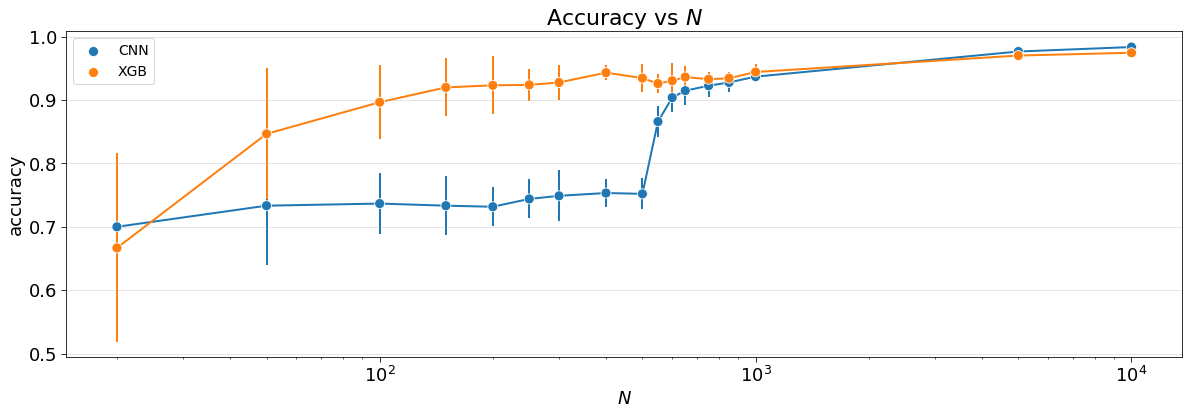

In [ ]:
fig = plt.figure(figsize=(20,6)) 
ax = fig.add_subplot(111)

ax = plot_utils.scatter_results(
    parameter=N_list,
    result=[performance['cnn_mean_accuracy'] for performance in performance_list],
    error=[performance['cnn_std_accuracy'] for performance in performance_list],
    fig=fig,
    ax=ax,
    label="CNN",
    par_label="$N$",
    metric_label="accuracy",
    color="tab:blue",
    lw=2,
    ls="-",
    title="Accuracy vs $N$",
)

ax = plot_utils.scatter_results(
    parameter=N_list,
    result=[performance['xgb_mean_accuracy'] for performance in performance_list],
    error=[performance['xgb_std_accuracy'] for performance in performance_list],
    fig=fig,
    ax=ax,
    label="XGB",
    par_label="$N$",
    metric_label="accuracy",
    color="tab:orange",
    lw=2,
    ls="-",
    title="Accuracy vs $N$",
)

ax.set_axisbelow(True)
ax.grid("y", "major", axis="y", alpha=0.4)
ax.set_xscale("log")

plt.show()

It is clear that XGBoost outperforms CNNs for small datasets, with $50\le N \le 500$ to be precise. With $N=20$ that is not the case, but we are talking about a point with high variance in which the accuracy can differ a lot due to stochasticity. Then, for $N> 500$ CNN starts to catch up, achieving optimal performances at higher dataset sizes.

## 1.b) Extracted features

First, we train a XGBoost model with a dataset of size $N=500$ and then we perform the features extraction based on this model.



In [ ]:
# time series data parameters
L       = 60
Z       = 12
A       = 500
DX      = 50
bias    = 5
n_class = 3
N       =500
seed    = 12345

# data generation
fname = generate_data.generate_data(N=N, seed=seed)

# load data
x = np.loadtxt("DATA/x_"+fname, delimiter=" ",dtype=float)
# load categories
c = np.loadtxt("DATA/y_"+fname, dtype=int)
# build time grid
t_grid = np.arange(0, L*N).reshape(N, L)
# format labels from categories
y = np.zeros((N, n_class))
for i in range(N):
    y[i][c[i]] = 1

# data rescaling
x_detrend = detrend(x)
x = standardize_all(x_detrend)

In [ ]:
df = get_df(x)

#extract features
x_features = extract_features(
    df, #our dataframe
    column_id='id', #sample id, from 0 to N
    column_sort='time', #timestep, from 0 to t
    column_kind=None, #we have only one feature
    column_value='value', #value of input 
    n_jobs=4 #number of cores
) 

#remove columns with NaN or inf
#x_features.replace([np.inf, -np.inf], np.nan)
#x_features = x_features.dropna(axis='columns') 

#split data into training and validation
dataset = Dataset(x_features, y, train_test_frac=0.7 ,valid_train_frac=0.3)

x_train = dataset.xtrain
y_train = dataset.ytrain
x_valid = dataset.xvalid
y_valid = dataset.yvalid
x_test  = dataset.xtest
y_test  = dataset.ytest

#rescale: in each feature, remove average and divide by std
train_avg = np.mean(x_train,axis=0)
test_avg  = np.mean(x_test,axis=0)
x_train -= train_avg
x_test  -= test_avg

train_std = np.std(x_train,axis=0)
test_std  = np.std(x_test,axis=0)
x_train  /= train_std
x_test  /= test_std 

#define parameters for xgboost
params = {'max_depth':6,'min_child_weight':1,\
        'learning_rate':0.3,'use_label_encoder':False}

#build model with given params
model_xgb = XGBClassifier(**params)

#fit
model_xgb.fit(x_train.values, np.argmax(y_train, axis=1))  

#predict labels on test set
y_pred_test = model_xgb.predict(x_test)

Feature Extraction: 100%|██████████| 20/20 [00:47<00:00,  2.40s/it]
[12:10:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = model_xgb.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

### Top 5 features:

In [ ]:
#print top 5 features
print("Top 5 features\n")
print("{:<2} {:<70} {:<10}".format("","Feature name","Feature importance"))
for i,k in enumerate(feat_imp.keys()):
    if i>4: break;
    print("{:<2} {:<70} {:<10}".format(i+1,k,feat_imp[k]))

Top 5 features

   Feature name                                                           Feature importance
1  value__c3__lag_1                                                       0.14067159593105316
2  value__cid_ce__normalize_False                                         0.13021141290664673
3  value__c3__lag_2                                                       0.0715719535946846
4  value__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"   0.07060516625642776
5  value__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)          0.0411791168153286


1. ```tsfresh.feature_extraction.feature_calculators.c3``` uses c3 statistics to measure non linearity in the time series &rarr; makes sense that it is the most significant feature as it focuses on non-linearities such as the injected signals that we try to classify. [[1]]

2. ```tsfresh.feature_extraction.feature_calculators.cid_ce``` aims to estimate the time series complexity. A more complex time series has more peaks, valleys etc.  &rarr; again this makes sense as the non-linearities we are injecting in the signals are actually peaks and valleys. [[2]]

3. ```tsfresh.feature_extraction.feature_calculators.c3```, this time with a different lag, so we are changing the time window on which this features operates to detect non-linearities.

4. ```tsfresh.feature_extraction.feature_calculators.agg_linear_trend``` calculates a linear least-squares regression for values of the time series that were aggregated over chunks versus the sequence from 0 up to the number of chunks minus one. This feature assumes the signal to be uniformly sampled. It will not use the time stamps to fit the model. The parameters attr controls which of the characteristics are returned. Possible extracted attributes are “pvalue”, “rvalue”, “intercept”, “slope”, “stderr”. The fourth most significant feature is characterized by the "intercept" attribute. [[3]]

5. ```tsfresh.feature_extraction.feature_calculators.cwt_coefficients``` calculates a Continuous wavelet transform for the Ricker wavelet, also known as the “Mexican hat wavelet”. This feature calculator takes three different parameter: widths, coeff and w. The feature calculator takes all the different widths arrays and then calculates the cwt one time for each different width array. Then the values for the different coefficient for coeff and width w are returned. [[4]]

[1]: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html?highlight=value__c3__lag_1%20#tsfresh.feature_extraction.feature_calculators.c3
[2]: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html?highlight=value__c3__lag_1%20#tsfresh.feature_extraction.feature_calculators.cid_ce
[3]: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html?highlight=agg%20linear%20trend#tsfresh.feature_extraction.feature_calculators.agg_linear_trend
[4]: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html?highlight=value__cwt_coefficients__coeff_4__w_2__widths_#tsfresh.feature_extraction.feature_calculators.cwt_coefficients



The importance of the first two stands out compared to the others in the top 5. The third one is also exactly the first one but with a slightly different attribute. For these three features we were also able to identify a relationship with the dataset itself and the classification problem we are trying to solve. For the other two features we were not able to identify a direct relationship with the data, moreover they are easily subject to be exchanged with other features for similar models trained with slightly different data.

## 2) Best XGBoost model for 2D data
In this section we try different parameters `(gamma, reg_lambda, n_estimators, ...)`, aiming to find the simplest yet effective XGBoost model which keeps a good accuracy

### Generate data

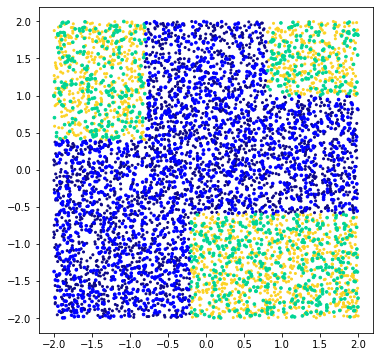

In [ ]:
S = 2
N = 8000

x = S*(2*np.random.rand(N,2)-1)
y = np.asarray([ 1 if (x0>-.2 and x1<-.6) or
                       (x0<-.8 and x1>.4) or
                       (x0>.8 and x1>1) else 0
                 for x0, x1 in zip(x[:,0], x[:,1])])

ds = Dataset(x, y, train_test_frac=0.7 ,valid_train_frac=0.3)

# plot train and test data
plt.figure(figsize=(6,6))
plt.scatter(ds.xtrain[:,0], ds.xtrain[:,1],
            c=ds.ytrain, cmap="plasma", vmax=1.1, s=4)
plt.scatter(ds.xtest[:,0], ds.xtest[:,1],
            c=ds.ytest, cmap="winter", vmax=1.2, s=7)
plt.show()


### Define list of parameters
In this section we defined different lists of parameters passed to `GridSearchCV`.

In [ ]:
gamma         = [0.1, 1, 10]
reg_lambda    = [.1, 1, 10]                 #[0.001, .01, .1, 1, 10]
n_estimators  = [3, 4]
max_depth     = [5]
learning_rate = [0.3, 0.5]
subsample     = [0.6, 0.7, 0.8]
tree_method   = ['exact', 'auto']
max_leaves    = [7]                         #[6, 7]
objective     = ['binary:logistic']

### Perform the `GridSearchCV`
In this section we perform a gridsearch on the lists of parameters defined above. Note that we performed various tries, whose results have been saved into `grd_results<n>.pkl` files. Looking at these results we defined the final lists showed above.

#### Take a look into previous results

In [9]:
# in order to read these files, please rename '_2207_gridsearch.py' to 'gridsearch.py'
# and correct the import instruction consequently

n = 7

for i in range(n):

    with open(f"_2207_grd_results{i}.pkl", 'rb') as f:
        grid = pickle.load(f)

    print(f"\nParameters considered in try #{i}:", grid.param_grid, sep='\n')
    grid.print_result(verbose=0)


Parameters considered in try #0:
{'gamma': [0], 'reg_lambda': [0.01], 'n_estimators': [5], 'max_depth': [5], 'learning_rate': array([0.3, 0.4]), 'subsample': array([0.6]), 'tree_method': ['exact'], 'max_leaves': [7], 'objective': ['binary:hinge']}
Best: 0.996428 using {'gamma': 0, 'learning_rate': 0.4, 'max_depth': 5, 'max_leaves': 7, 'n_estimators': 5, 'objective': 'binary:hinge', 'reg_lambda': 0.01, 'subsample': 0.6, 'tree_method': 'exact'}

Parameters considered in try #1:
{'gamma': [0], 'reg_lambda': [0.01], 'n_estimators': [4, 5, 6, 7, 8, 9, 10], 'max_depth': [4, 5, 6], 'learning_rate': array([0.3, 0.4]), 'subsample': array([0.6]), 'tree_method': ['exact'], 'max_leaves': [7], 'objective': ['binary:hinge']}
Best: 0.995915 using {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 4, 'max_leaves': 7, 'n_estimators': 7, 'objective': 'binary:hinge', 'reg_lambda': 0.01, 'subsample': 0.6, 'tree_method': 'exact'}

Parameters considered in try #2:
{'gamma': [0, 100], 'reg_lambda': [0.001, 10]

#### Final results

In [ ]:
model_gridsearch = XGBClassifier(seed=1, verbosity=1)

In [ ]:
param_grid = dict(gamma=gamma, reg_lambda=reg_lambda, n_estimators=n_estimators,
                  max_depth=max_depth, learning_rate=learning_rate, subsample=subsample,
                  tree_method=tree_method, max_leaves=max_leaves, objective=objective)

# perform grid search
grid = gridsearch.GridSearch(ds.xtrain, ds.ytrain, model_gridsearch, param_grid, verbose=1 )
grid.get_result()

Fitting 4 folds for each of 216 candidates, totalling 864 fits
[10:15:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=1, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=1),
             n_jobs=-1,
             param_grid={'g

In [ ]:
grid.print_result()

Best: 0.998979 using {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'max_leaves': 7, 'n_estimators': 4, 'objective': 'binary:logistic', 'reg_lambda': 0.1, 'subsample': 0.8, 'tree_method': 'exact'}
0.998979 (0.000722) with: {'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 5, 'max_leaves': 7, 'n_estimators': 4, 'objective': 'binary:logistic', 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'auto'}
0.998979 (0.000722) with: {'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 5, 'max_leaves': 7, 'n_estimators': 4, 'objective': 'binary:logistic', 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'exact'}
0.998979 (0.000722) with: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'max_leaves': 7, 'n_estimators': 4, 'objective': 'binary:logistic', 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'auto'}
0.998979 (0.000722) with: {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'max_leaves': 7, 'n_estimators': 4, 'objective': 'binary:logistic', 'reg_lambda': 0.1, 'subsample': 0.

In [ ]:
# save results
#with open("grd_results6.pkl", 'wb') as f:
#    pickle.dump(grid, f)


errors: 0.12%


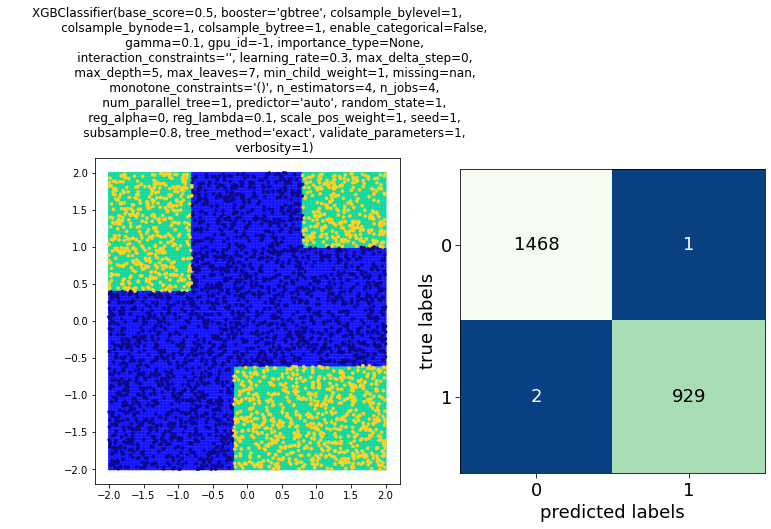

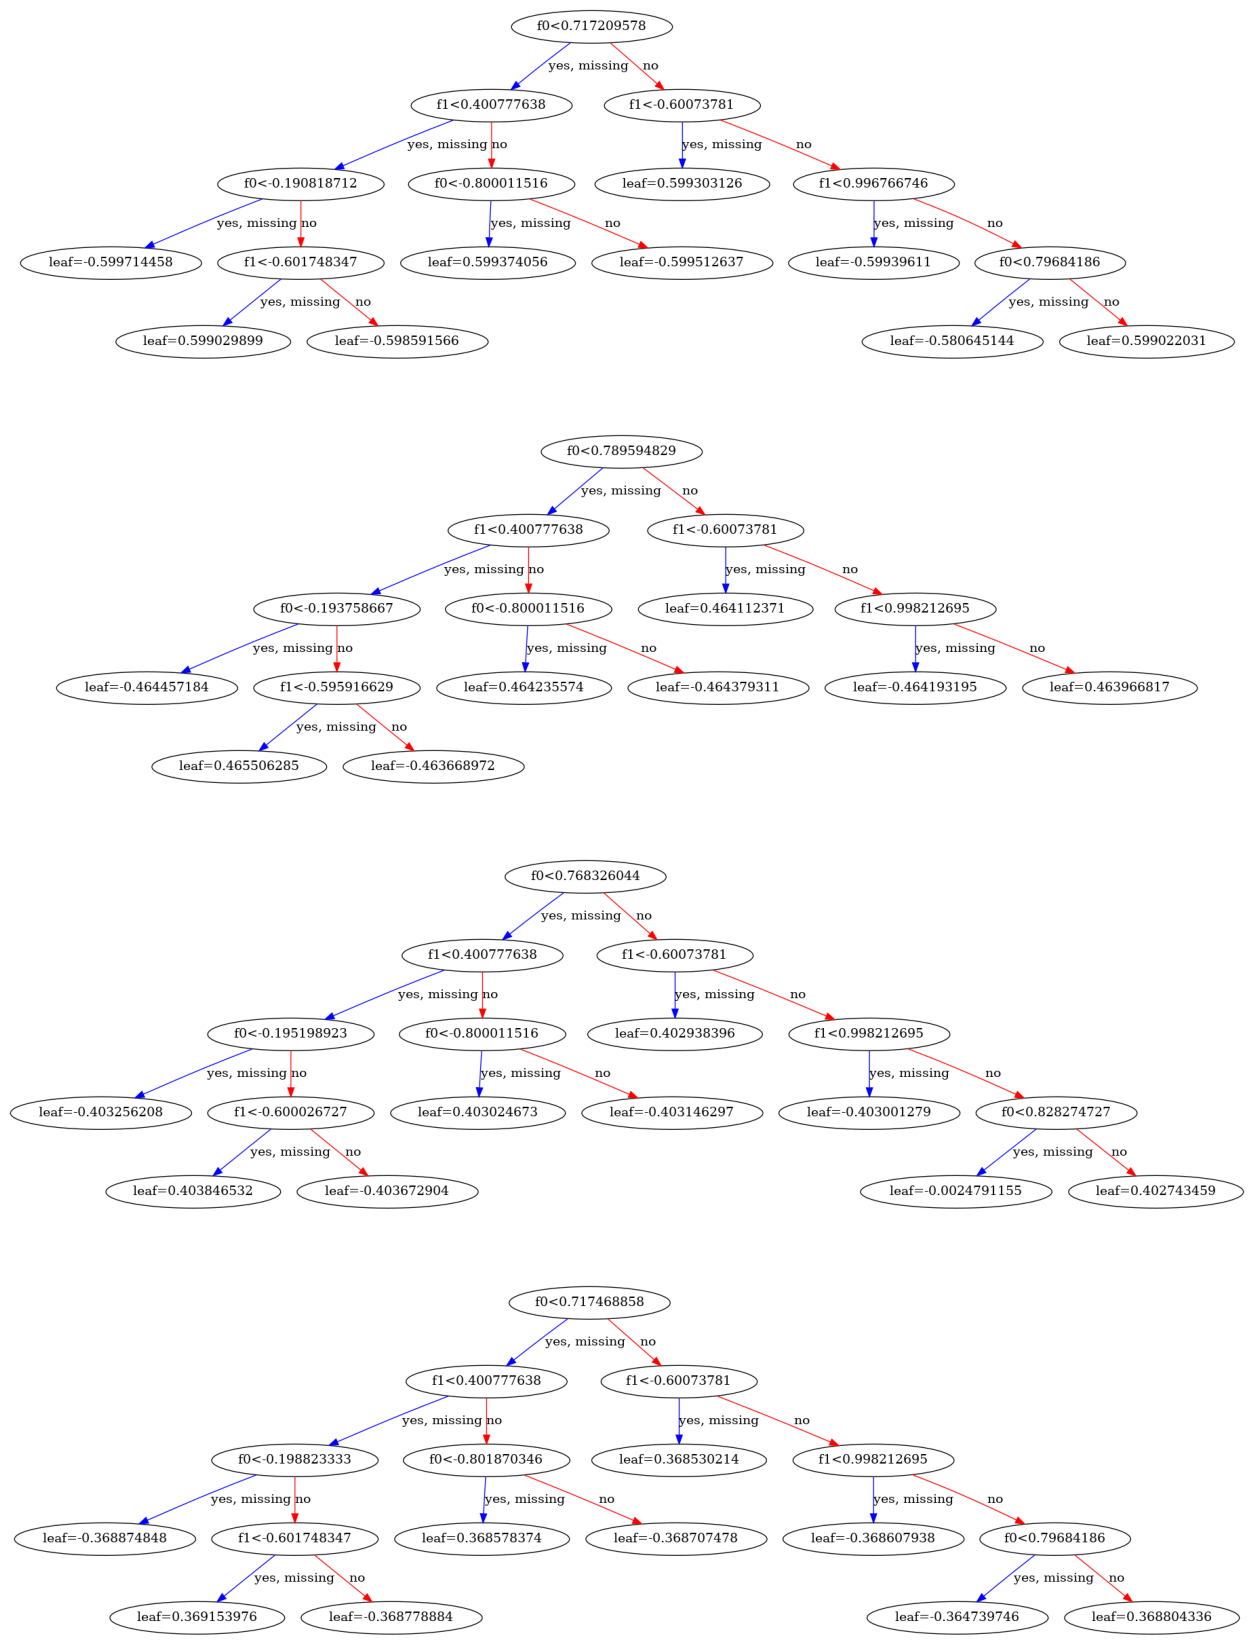

In [ ]:
# uncomment this to read gridsearch results from file
#with open("grd_results6.pkl", 'rb') as f:
#    grid = pickle.load(f)
best_model = grid.grid_result.best_estimator_
plot_utils.show_perf(best_model, ds, S)

### Try different data
In this section we train our model over a different dataset, but retaining the same structure, _i.e_ 6 constraints.

#### Generate data

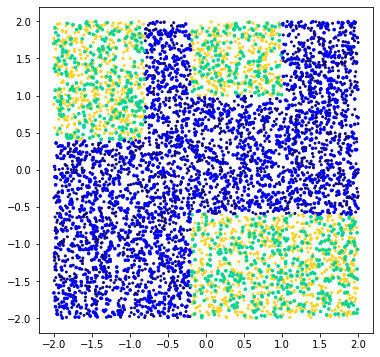

In [ ]:

x = S*(2*np.random.rand(N,2)-1)
y = np.asarray([ 1 if (x0>-.2 and (x1<-.6 or (x0<1 and x1>1))) or
                      (x0<-.8 and x1>.4) else 0
                   for x0, x1 in zip(x[:,0], x[:,1])])

ds2 = Dataset(x, y, train_test_frac=0.7 ,valid_train_frac=0.3)

# plot train and test data
plt.figure(figsize=(6,6))
plt.scatter(ds2.xtrain[:,0], ds2.xtrain[:,1],
            c=ds2.ytrain, cmap="plasma", vmax=1.1, s=4)
plt.scatter(ds2.xtest[:,0], ds2.xtest[:,1],
            c=ds2.ytest, cmap="winter", vmax=1.2, s=7)
plt.show()

#### Fit and plot performances

/root/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
errors: 0.12%


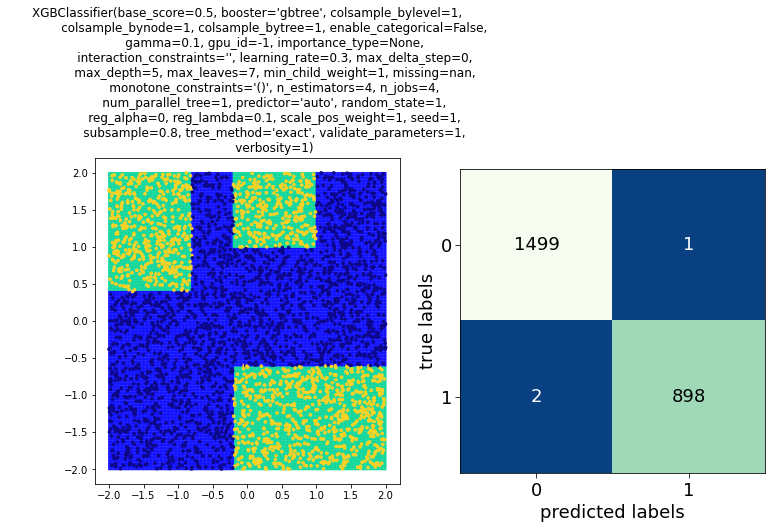

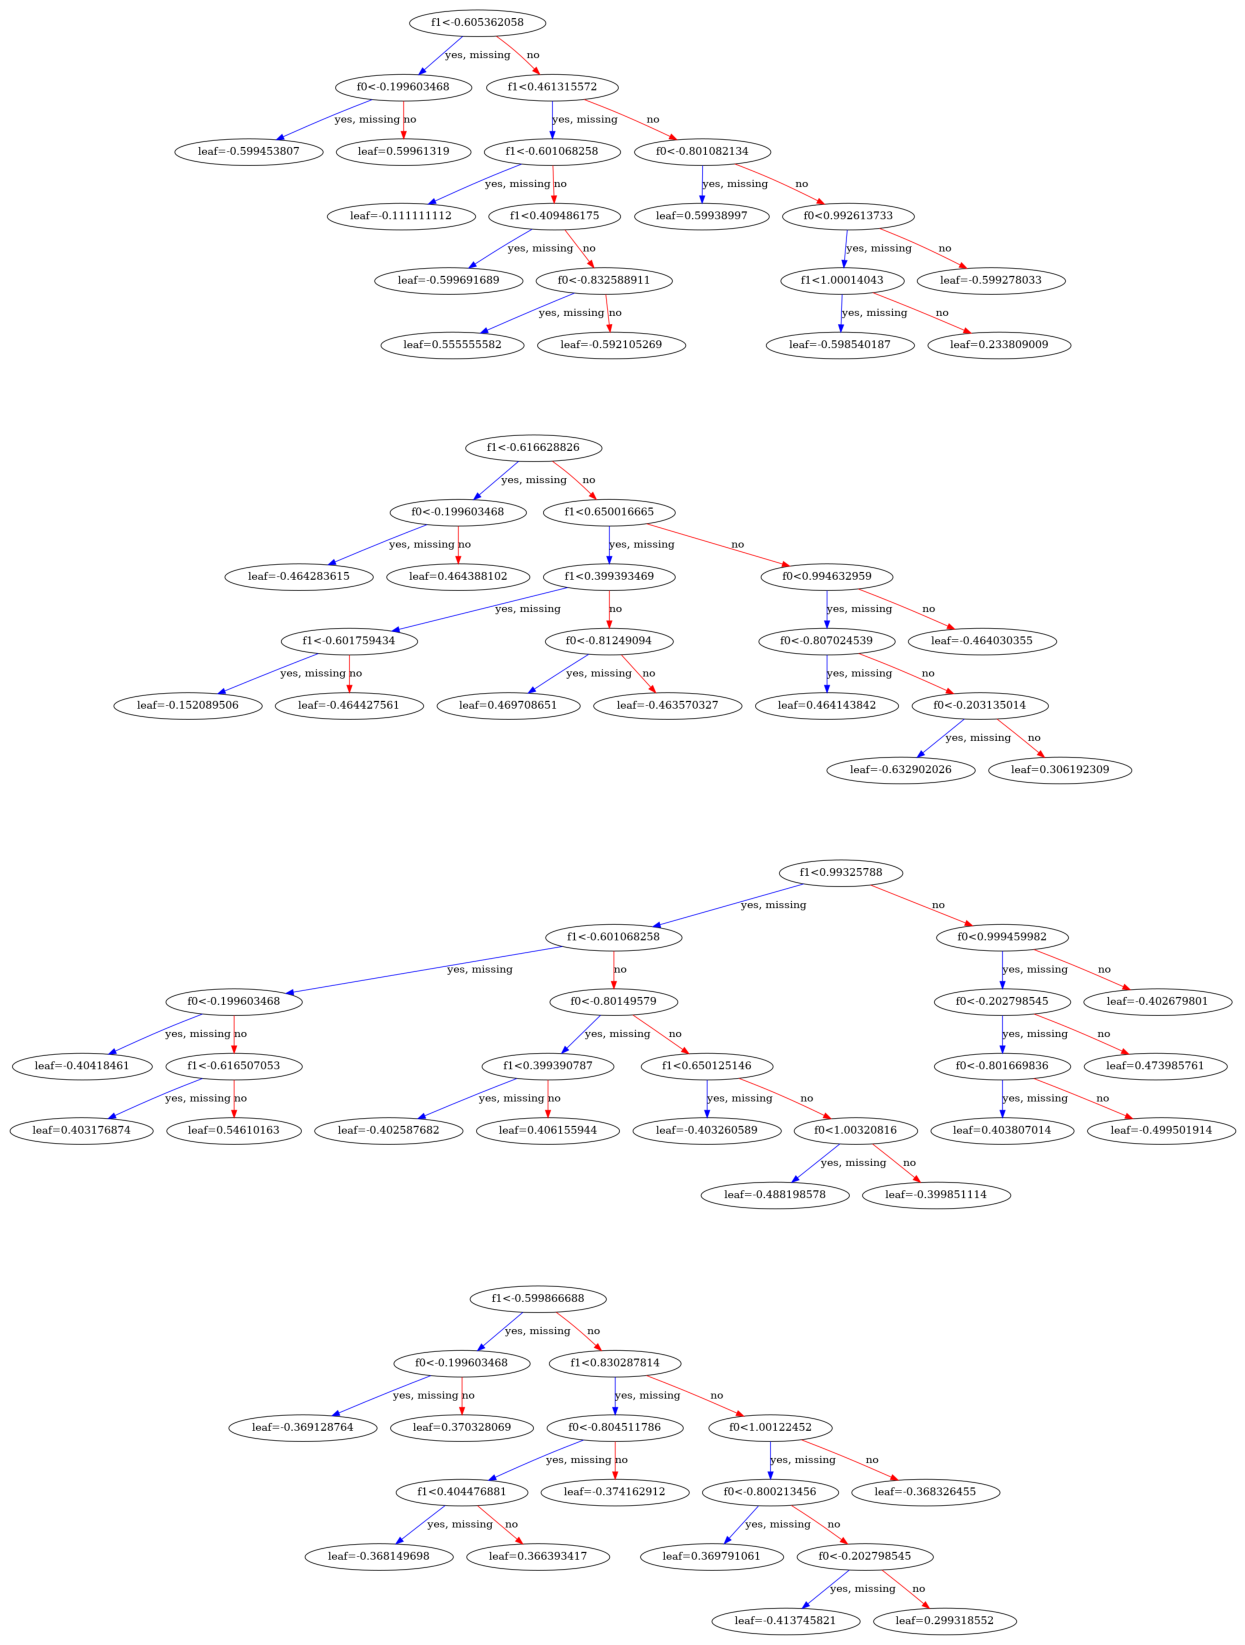

In [ ]:
model = XGBClassifier(**best_model.get_params())

model.fit(ds2.xtrain, ds2.ytrain, eval_metric='logloss', verbose=1)
plot_utils.show_perf(model, ds2, S, 'tree-classif2.png')

we see that the model works very well also over slightly different data, given a maximum of 6 constraints.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>